## Example of Making Predictions

In this notebook I am going to use a random forest to classify the text.

I want to keep this simple so I want the output to be a value from the set {-3, -2, -1, 0, 1}.
I'm going to use the individual lowercase words from the text as the features.

The aim of this is not to produce a good model, it's to show the end to end process for making a model and producing a submission.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

from src.paths import DATA_CSV_TRAIN, DATA_CSV_TEST

In [2]:
df = pd.read_csv(DATA_CSV_TRAIN)

In [3]:
df.target.astype(int).unique()

array([ 0, -1, -3, -2,  1])

---

### Random Forest Classifier

Here we train a random forest classifier on 5 folds.
The text is converted to features by using a [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).
This produces a count for each distinct token after performing some basic preprocessing (lower case, strip accents).

In [4]:
%%time

kf = KFold()

vectorizer = CountVectorizer()
vectorizer.fit(df.excerpt)

forests = []
predictions = []

for train_indices, test_indices in kf.split(df):
    train_df = df.iloc[train_indices].copy()
    test_df = df.iloc[test_indices].copy()

    train_array = vectorizer.transform(train_df.excerpt).toarray()

    rf = RandomForestClassifier(max_features=1_000, oob_score=True)
    rf.fit(
        train_array,
        train_df.target.astype(int)
    )

    test_array = vectorizer.transform(test_df.excerpt).toarray()
    test_df["prediction"] = rf.predict(test_array)

    forests.append(rf)
    predictions.append(test_df[["target", "prediction"]])

CPU times: user 1min 15s, sys: 3.32 s, total: 1min 18s
Wall time: 1min 18s


---

### Random Forest Results

Now that it's trained we can see how well it performs.

In [5]:
all_predictions = pd.concat(predictions)

print(classification_report(
    all_predictions.target.astype(int),
    all_predictions.prediction,
    zero_division=0
))

              precision    recall  f1-score   support

          -3       0.00      0.00      0.00        75
          -2       0.37      0.05      0.08       421
          -1       0.40      0.27      0.32       835
           0       0.60      0.91      0.72      1447
           1       0.00      0.00      0.00        56

    accuracy                           0.55      2834
   macro avg       0.27      0.25      0.23      2834
weighted avg       0.48      0.55      0.48      2834



This plots the confusion matrix of the predictions.
This block of code is a hacked around version of something that Katie and Chloe came up with.
Thank you.

In [6]:
import plotly.figure_factory as ff
import plotly.graph_objects as go
import numpy as np

def plotly_confusion_matrix(df: pd.DataFrame):
    df = df.copy()
    df["target"] = df.target.astype(int)
    
    labels = [-3, -2, -1, 0, 1]
    test_labels = df["target"].tolist()
    pred_labels = df["prediction"].tolist()
    
    # make everything but the diagonal negative to mark the wrong values as incorrect
    matrix = confusion_matrix(df["target"], df["prediction"], normalize="true")
    correct_incorrect_multiplicand = np.ones(matrix.shape)
    correct_incorrect_multiplicand *= -1
    np.fill_diagonal(correct_incorrect_multiplicand, 1)
    
    matrix = matrix * correct_incorrect_multiplicand
    
    fig = ff.create_annotated_heatmap(
        z=matrix,
        x=[str(f"{label} (n = {pred_labels.count(label)})") for label in labels],
        y=[str(f"{label} (n = {test_labels.count(label)})") for label in labels],
        colorscale=["red", "white", "green"],
        annotation_text=confusion_matrix(df["target"], df["prediction"]),
        zmin=-1,
        zmax=1,
        showscale=True,
        colorbar=dict(
            tickvals=[-1, 1],
            ticktext=['0% Correct Labels', '100% Correct Labels']
        )
    )
    fig.update_layout(
        title_text=f"True vs. Predicted Readability",
        title_x=0.5,
        xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Predicted Readability')),
        yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='True Readability'))
    )
    return fig

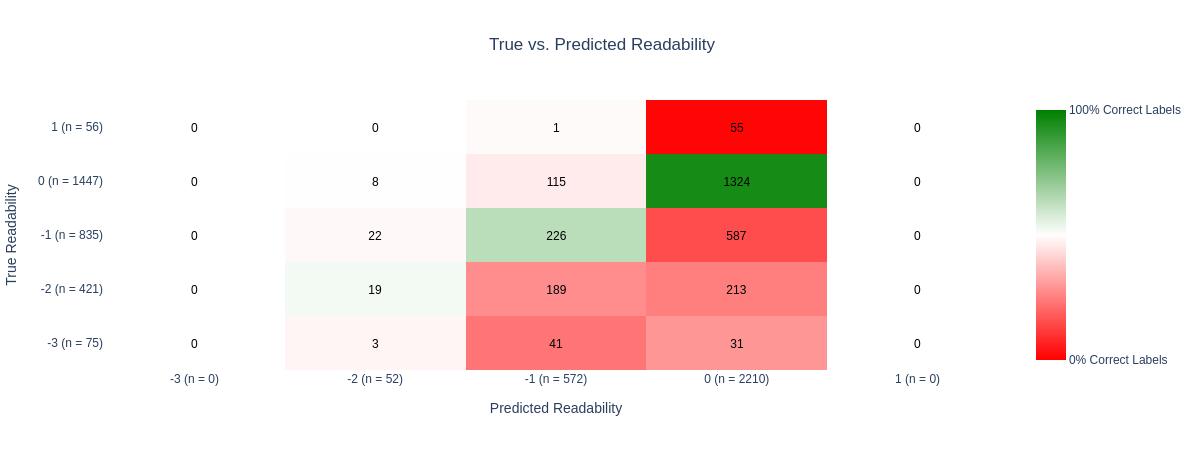

In [7]:
plotly_confusion_matrix(all_predictions)

Finally we can run the competition evaluation against these predictions to see what score we would get.

In [8]:
((all_predictions.target - all_predictions.prediction) ** 2).mean() ** 0.5

1.1949974834136678

---

### Random Forest Submission

If we wanted to turn the 5 random forests into a submission then we could ensemble the predictions they make over the test set.
The simplest ensemble is to take the mean of the different suggestions, as we are treating them as continuous.

There are 7 excerpts to predict in the test set, so lets see what generating that submission would look like.

In [9]:
test_df = pd.read_csv(DATA_CSV_TEST)

def predict_all(texts: pd.Series, forest: RandomForestClassifier, vectorizer: CountVectorizer) -> pd.Series:
    text_array = vectorizer.transform(texts).toarray()
    return forest.predict(text_array)

raw_predictions = np.array([
    forest.predict(vectorizer.transform(test_df.excerpt).toarray())
    for forest in forests
])

predictions = raw_predictions.mean(axis=0)

submission_df = test_df[["id"]].copy()
submission_df["target"] = predictions

In [10]:
submission_df

id  target
0  c0f722661     0.0
1  f0953f0a5     0.0
2  0df072751     0.0
3  04caf4e0c    -1.2
4  0e63f8bea     0.0
5  12537fe78     0.0
6  965e592c0     0.0

We all know this is a terrible submission so I am going to refrain from submitting it.
Let's assume I would've got a score of around 1.2.
Can you beat that?

---

### Random Forest Comments

The random forest classifier using the count vectorizer is a very poor classifier for this task.
At the time of writing this score would place $\frac{1077}{1111}$ or in the bottom 3% of submissions.

The biggest problem with this approach is likely the count vectorizer.
This loses all positional information about the text, forming a bag of words.
There are many improvements to a bag of words that can be easily applied.

Another big problem is making a continuous task discrete.
A classifier which can produce continuous outputs would be more suitable for this task.

More broadly, the problem may benefit from a bit of consideration.
What makes text hard to read?
What features could you extract that would best signal that?

---

### Kaggle Discussions

Each competition has a discussion forum.
The one for this competition is [here](https://www.kaggle.com/c/commonlitreadabilityprize/discussion).

The discussions for a competition are excellent.
They frequently give excellent tips for techniques or tools that can be used to make submissions.
For example [here](https://www.kaggle.com/c/commonlitreadabilityprize/discussion/239780) is a discussion of different feature engineering techniques that could help.

One reason that people share ideas around submissions is because valuable submissions (based on upvotes) lead to better kaggle rankings.
If you find a post or comment particularly good consider upvoting it.